## ACTIVIDAD 3


##EJEMPLO 1 ARIMA

# Bitcoin Price. Prediction by ARIMA

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Data Exploration

In [ ]:
# Load data
df = pd.read_csv('bitstampUSD')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [ ]:
# Unix-time to
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean()

# Resampling to monthly frequency
df_month = df.resample('M').mean()

# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()

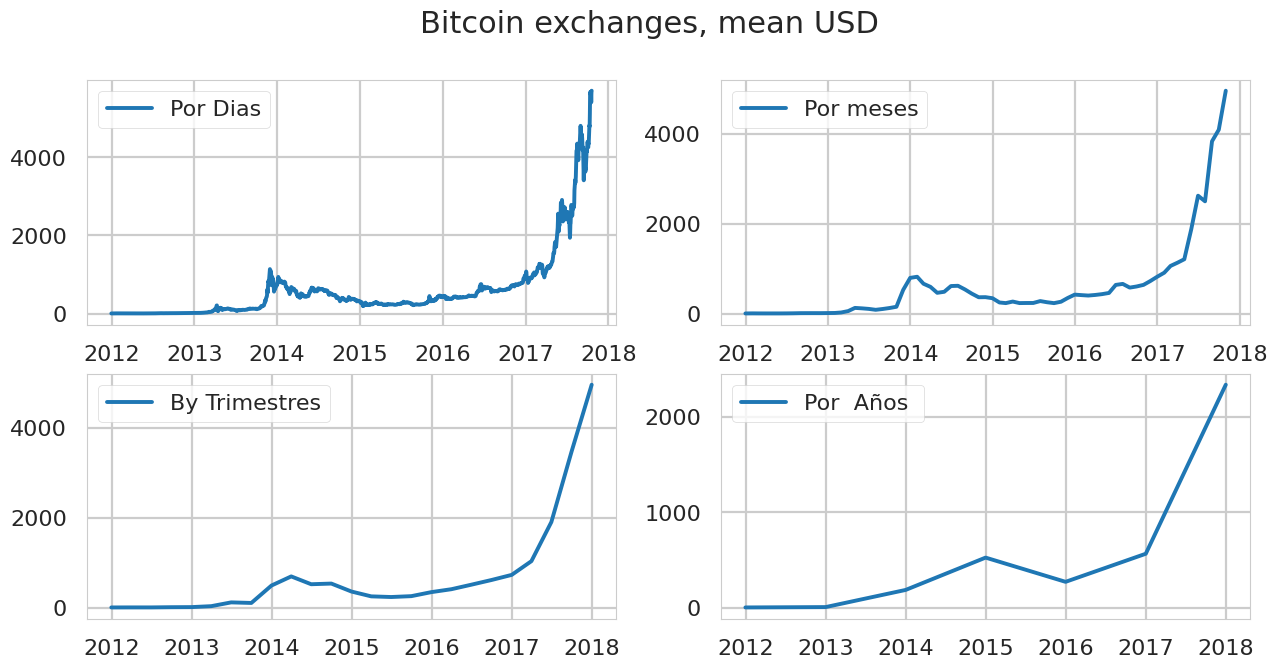

In [ ]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='Por Dias')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='Por meses')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Trimestres')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='Por  Años ')
plt.legend()

# plt.tight_layout()
plt.show()

I will predict bitcoin prices by months.

## Stationarity check and STL-decomposition of the series

Dickey–Fuller test: p=1.000000


<Figure size 1500x700 with 0 Axes>

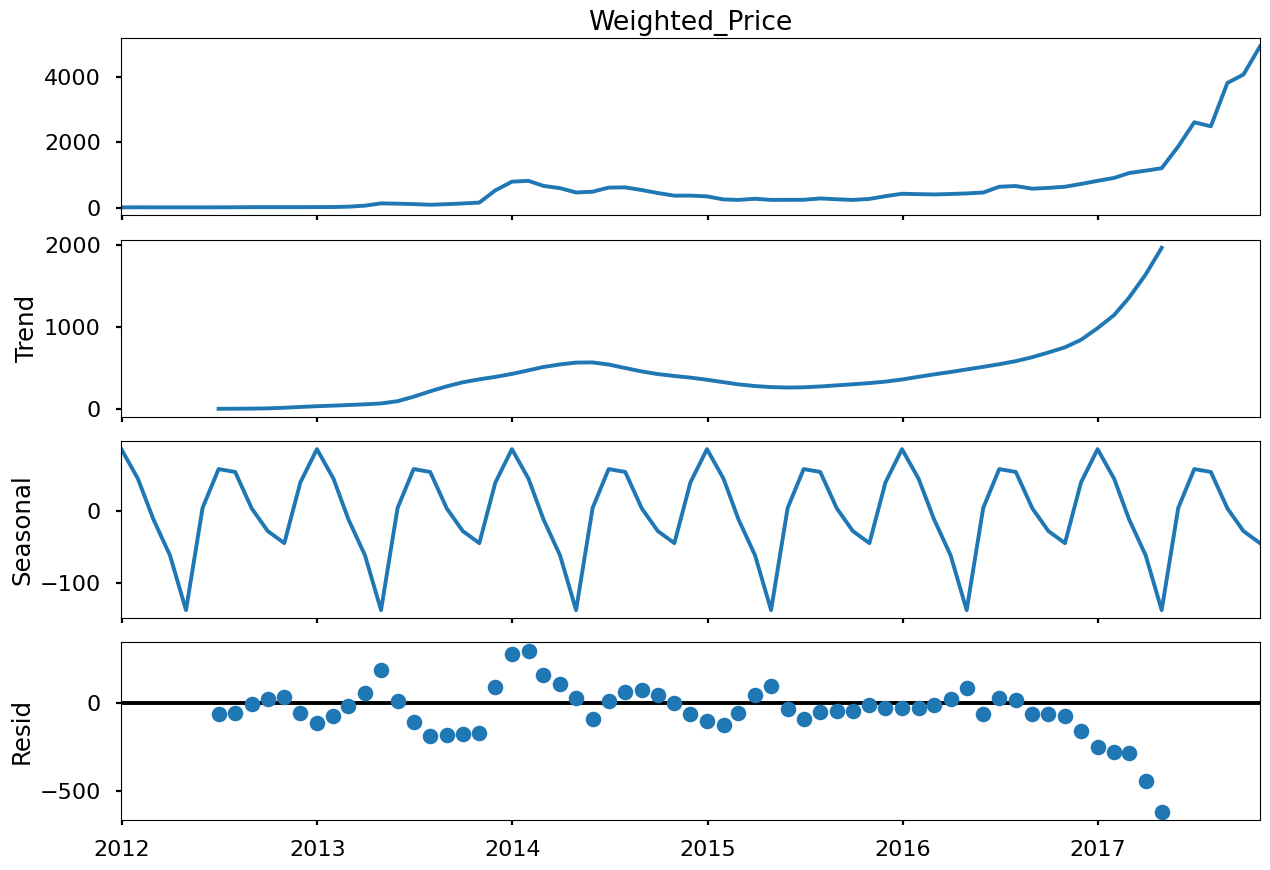

In [ ]:
plt.figure(figsize=[15,7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])
plt.show()

The series are not stationary.

## Box-Cox Transformations

In [ ]:
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=1.000000


The series are not stationary.

## Seasonal differentiation

In [ ]:
# Seasonal differentiation
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.166401


The series are not stationary.

## Regular differentiation

Dickey–Fuller test: p=0.024551


<Figure size 1500x700 with 0 Axes>

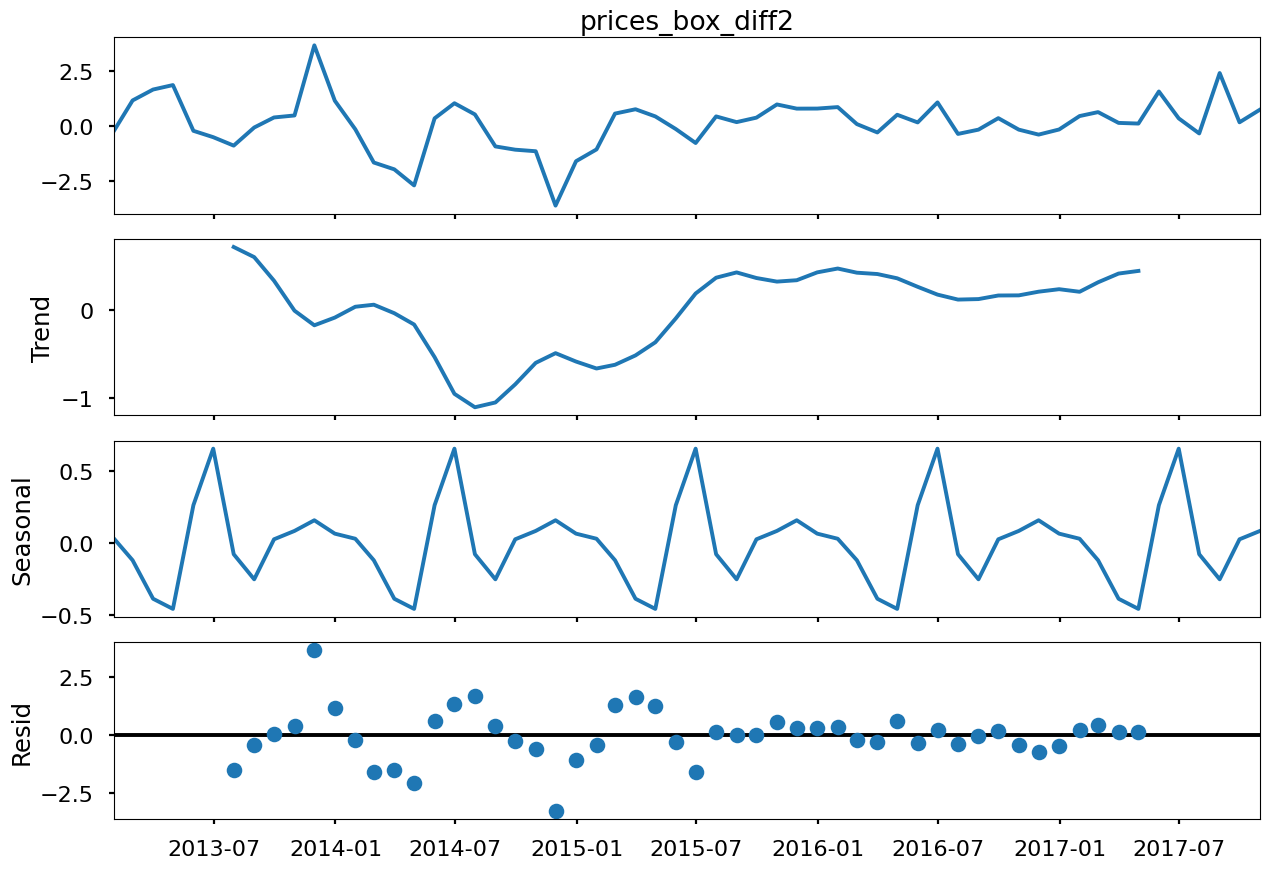

In [ ]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1)
plt.figure(figsize=(15,7))

# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])[1])

plt.show()

The series are stationary.

## Model Selection

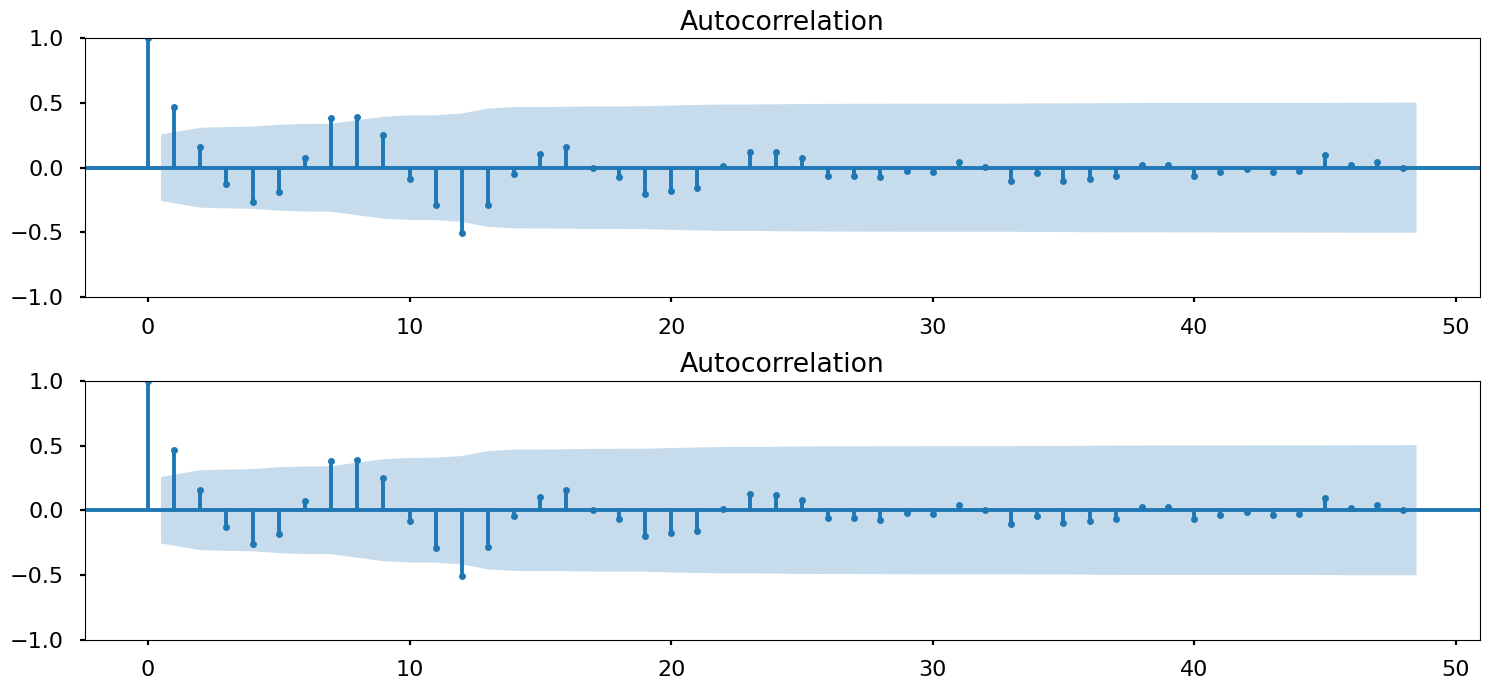

In [ ]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
plt.figure(figsize=(15,7))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(df_month.prices_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [ ]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

      parameters         aic
49  (2, 2, 0, 1)  145.154089
19  (1, 0, 0, 1)  146.056353
21  (1, 0, 1, 1)  146.829628
51  (2, 2, 1, 1)  147.106157
50  (2, 2, 1, 0)  147.129927
                                      SARIMAX Results                                       
Dep. Variable:                   Weighted_Price_box   No. Observations:                   71
Model:             SARIMAX(2, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 -66.577
Date:                              Mon, 18 Sep 2023   AIC                            145.154
Time:                                      04:56:44   BIC                            157.517
Sample:                                  12-31-2011   HQIC                           149.970
                                       - 10-31-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---

## Analysis of residues

Dickey–Fuller test:: p=0.000000


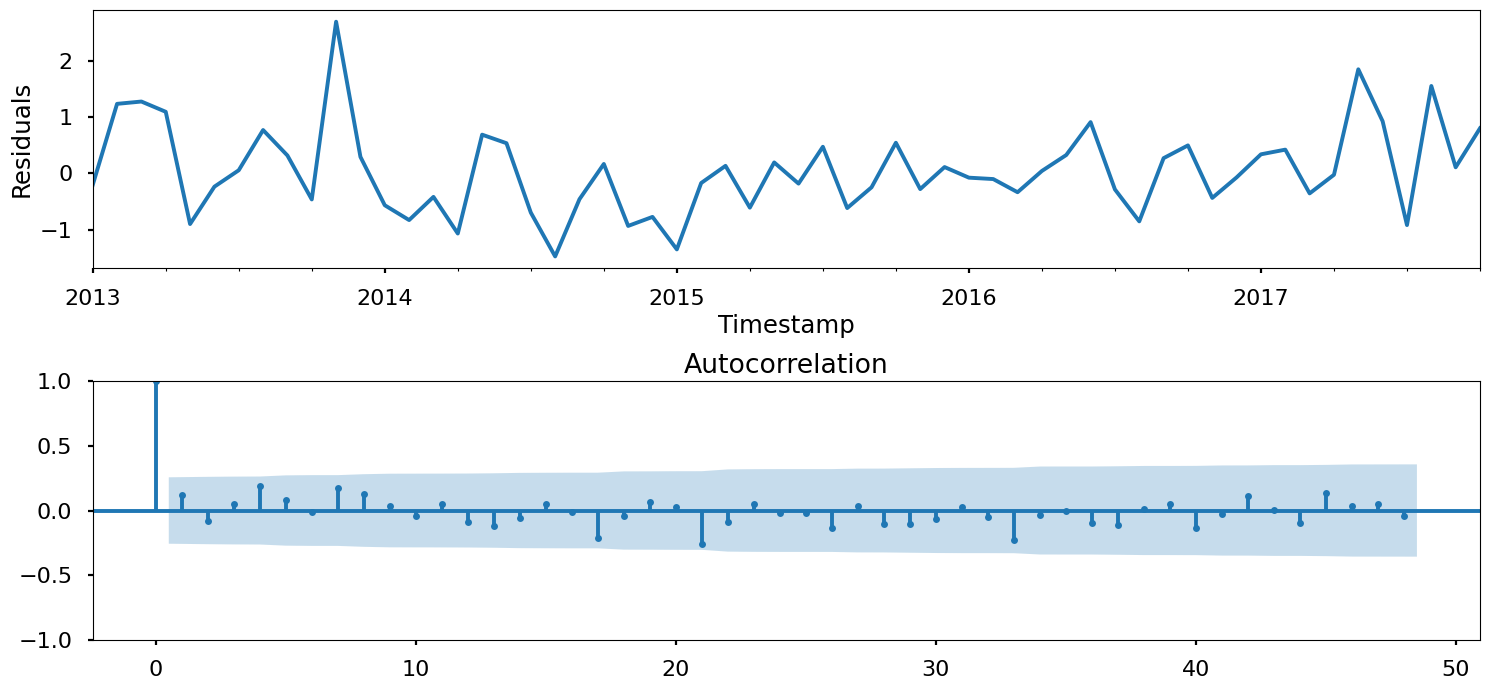

In [ ]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

It`s OK.

## Prediction

In [ ]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

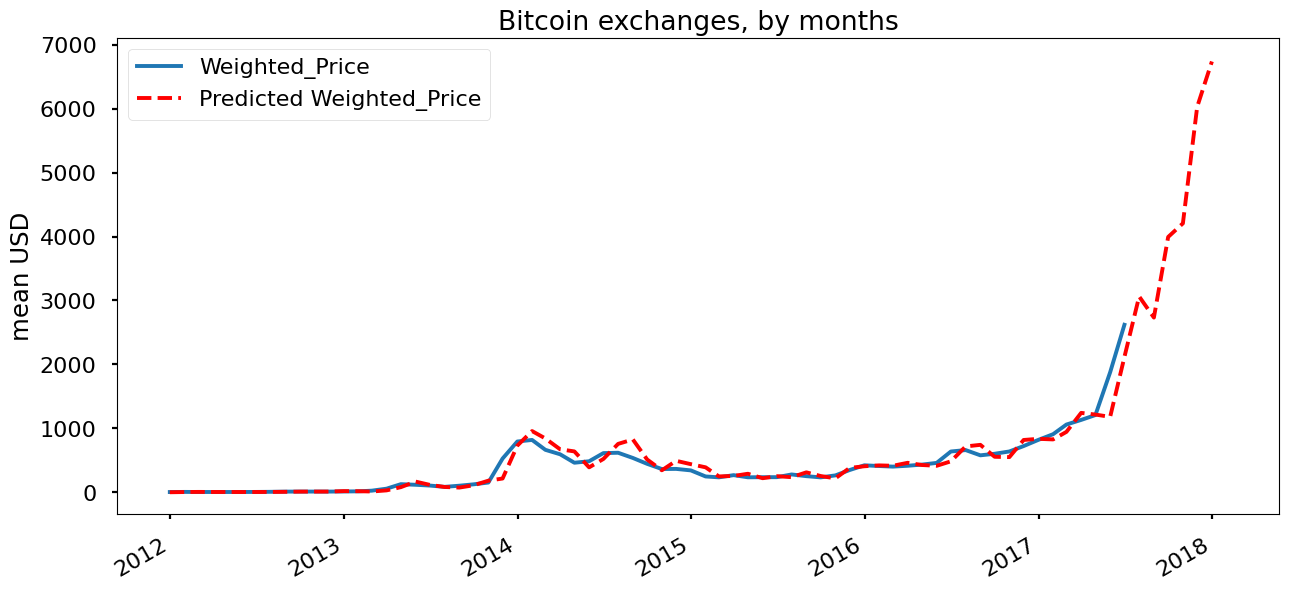

In [ ]:
# Prediction
df_month2 = df_month[['Weighted_Price']]
date_list = [datetime(2017, 6, 30), datetime(2017, 7, 31), datetime(2017, 8, 31), datetime(2017, 9, 30),
             datetime(2017, 10, 31), datetime(2017, 11, 30), datetime(2017, 12, 31), datetime(2018, 1, 31),
             datetime(2018, 1, 28)]
future = pd.DataFrame(index=date_list, columns= df_month.columns)
df_month2 = pd.concat([df_month2, future])
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=75), lmbda)
plt.figure(figsize=(15,7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel('mean USD')
plt.show()

##EJEMPLO 2 APRIORI

In [ ]:

import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



# Reading and Cleaning Data


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns

In [ ]:
df = pd.read_csv("bread basket.csv")

In [ ]:
df.head()

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,30-10-2016 09:58,morning,weekend
1,2,Scandinavian,30-10-2016 10:05,morning,weekend
2,2,Scandinavian,30-10-2016 10:05,morning,weekend
3,3,Hot chocolate,30-10-2016 10:07,morning,weekend
4,3,Jam,30-10-2016 10:07,morning,weekend


In [ ]:
df.describe()

,Transaction
count,20507.000000
mean,4976.202370
std,2796.203001
min,1.000000
25%,2552.000000
50%,5137.000000
75%,7357.000000
max,9684.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB


In [ ]:
# Converting the 'date_time' column into the right format
df['date_time'] = pd.to_datetime(df['date_time'])

In [ ]:
df.head(10)

,Transaction,Item,date_time,period_day,weekday_weekend
0,1,Bread,2016-10-30 09:58:00,morning,weekend
1,2,Scandinavian,2016-10-30 10:05:00,morning,weekend
2,2,Scandinavian,2016-10-30 10:05:00,morning,weekend
3,3,Hot chocolate,2016-10-30 10:07:00,morning,weekend
4,3,Jam,2016-10-30 10:07:00,morning,weekend
5,3,Cookies,2016-10-30 10:07:00,morning,weekend
6,4,Muffin,2016-10-30 10:08:00,morning,weekend
7,5,Coffee,2016-10-30 10:13:00,morning,weekend
8,5,Pastry,2016-10-30 10:13:00,morning,weekend
9,5,Bread,2016-10-30 10:13:00,morning,weekend


In [ ]:
# Count of unique customers
df['Transaction'].nunique()

9465

In [ ]:
# Extracting date
df['date'] = df['date_time'].dt.date

#Extracting time
df['time'] = df['date_time'].dt.time

# Extracting month and replacing it with text
df['month'] = df['date_time'].dt.month
df['month'] = df['month'].replace((1,2,3,4,5,6,7,8,9,10,11,12),
                                          ('January','February','March','April','May','June','July','August',
                                          'September','October','November','December'))

# Extracting hour
df['hour'] = df['date_time'].dt.hour
# Replacing hours with text
hour_in_num = (1,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
hour_in_obj = ('1-2','7-8','8-9','9-10','10-11','11-12','12-13','13-14','14-15',
               '15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-24')
df['hour'] = df['hour'].replace(hour_in_num, hour_in_obj)

# Extracting weekday and replacing it with text
df['weekday'] = df['date_time'].dt.weekday
df['weekday'] = df['weekday'].replace((0,1,2,3,4,5,6),
                                          ('Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'))

# dropping date_time column
df.drop('date_time', axis = 1, inplace = True)

In [ ]:
df.head()

,Transaction,Item,period_day,weekday_weekend,date,time,month,hour,weekday
0,1,Bread,morning,weekend,2016-10-30,09:58:00,October,9-10,Sunday
1,2,Scandinavian,morning,weekend,2016-10-30,10:05:00,October,10-11,Sunday
2,2,Scandinavian,morning,weekend,2016-10-30,10:05:00,October,10-11,Sunday
3,3,Hot chocolate,morning,weekend,2016-10-30,10:07:00,October,10-11,Sunday
4,3,Jam,morning,weekend,2016-10-30,10:07:00,October,10-11,Sunday


In [ ]:
# cleaning the item column
df['Item'] = df['Item'].str.strip()
df['Item'] = df['Item'].str.lower()

In [ ]:
df.head()

,Transaction,Item,period_day,weekday_weekend,date,time,month,hour,weekday
0,1,bread,morning,weekend,2016-10-30,09:58:00,October,9-10,Sunday
1,2,scandinavian,morning,weekend,2016-10-30,10:05:00,October,10-11,Sunday
2,2,scandinavian,morning,weekend,2016-10-30,10:05:00,October,10-11,Sunday
3,3,hot chocolate,morning,weekend,2016-10-30,10:07:00,October,10-11,Sunday
4,3,jam,morning,weekend,2016-10-30,10:07:00,October,10-11,Sunday


# Data Visualization

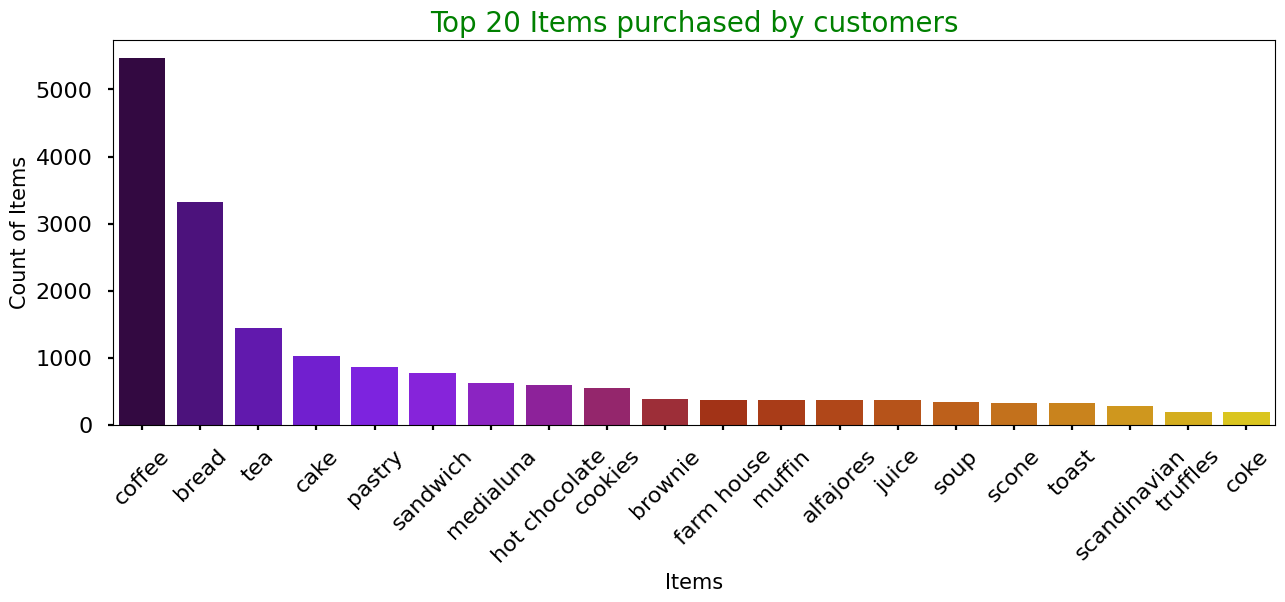

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x = df.Item.value_counts().head(20).index, y = df.Item.value_counts().head(20).values, palette = 'gnuplot')
plt.xlabel('Items', size = 15)
plt.xticks(rotation=45)
plt.ylabel('Count of Items', size = 15)
plt.title('Top 20 Items purchased by customers', color = 'green', size = 20)
plt.show()

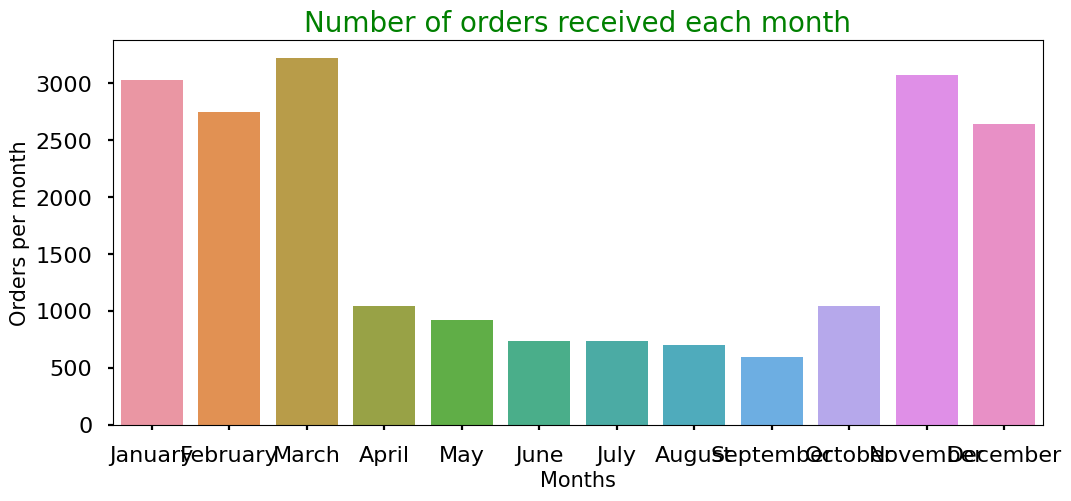

In [ ]:
monthTran = df.groupby('month')['Transaction'].count().reset_index()
monthTran.loc[:,"monthorder"] = [4,8,12,2,1,7,6,3,5,11,10,9]
monthTran.sort_values("monthorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = monthTran, x = "month", y = "Transaction")
plt.xlabel('Months', size = 15)
plt.ylabel('Orders per month', size = 15)
plt.title('Number of orders received each month', color = 'green', size = 20)
plt.show()


plt.show()

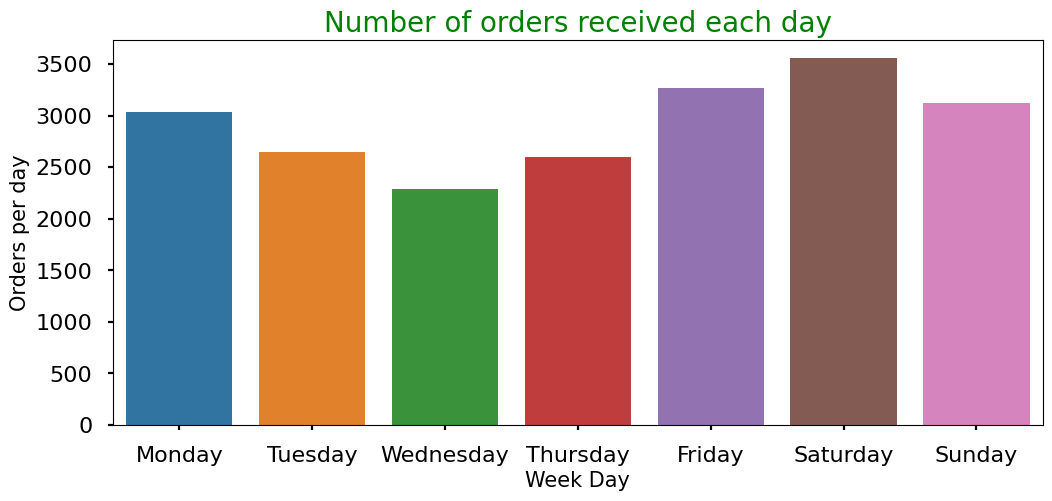

In [ ]:
weekTran = df.groupby('weekday')['Transaction'].count().reset_index()
weekTran.loc[:,"weekorder"] = [4,0,5,6,3,1,2]
weekTran.sort_values("weekorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = weekTran, x = "weekday", y = "Transaction")
plt.xlabel('Week Day', size = 15)
plt.ylabel('Orders per day', size = 15)
plt.title('Number of orders received each day', color = 'green', size = 20)
plt.show()


plt.show()

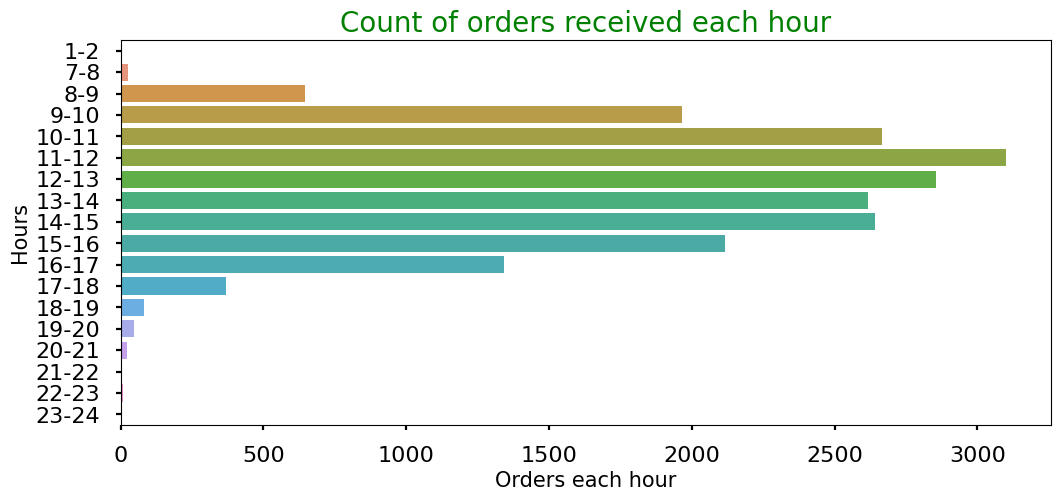

In [ ]:
hourTran = df.groupby('hour')['Transaction'].count().reset_index()
hourTran.loc[:,"hourorder"] = [1,10,11,12,13,14,15,16,17,18,19,20,21,22,23,7,8,9]
hourTran.sort_values("hourorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = hourTran, x = "Transaction", y = "hour")
plt.ylabel('Hours', size = 15)
plt.xlabel('Orders each hour', size = 15)
plt.title('Count of orders received each hour', color = 'green', size = 20)
plt.show()

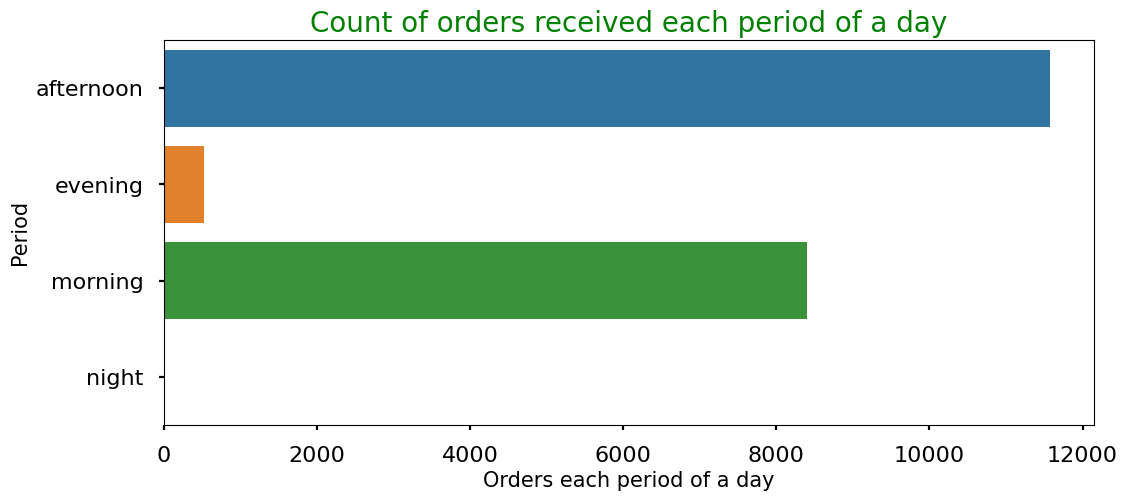

In [ ]:
dayTran = df.groupby('period_day')['Transaction'].count().reset_index()
# dayTran.loc[:,"hourorder"] = [1,10,11,12,13,14,15,16,17,18,19,20,21,22,23,7,8,9]
# dayTran.sort_values("hourorder",inplace=True)

plt.figure(figsize=(12,5))
sns.barplot(data = dayTran, x = "Transaction", y = "period_day")
plt.ylabel('Period', size = 15)
plt.xlabel('Orders each period of a day', size = 15)
plt.title('Count of orders received each period of a day', color = 'green', size = 20)
plt.show()

In [ ]:
dates = df.groupby('date')['Transaction'].count().reset_index()
dates = dates[dates['Transaction']>=200].sort_values('date').reset_index(drop = True)

dates = pd.merge(dates, df[['date','weekday']], on = 'date', how = 'inner')
dates.drop_duplicates(inplace =True)
dates

,date,Transaction,weekday
0,2016-05-11,275,Wednesday
275,2016-11-19,209,Saturday
484,2016-12-11,221,Sunday
705,2017-01-28,237,Saturday
942,2017-02-18,227,Saturday
1169,2017-03-25,246,Saturday
1415,2017-04-02,292,Sunday
1707,2017-04-03,257,Monday
1964,2017-08-04,205,Friday
2169,2017-11-03,203,Friday


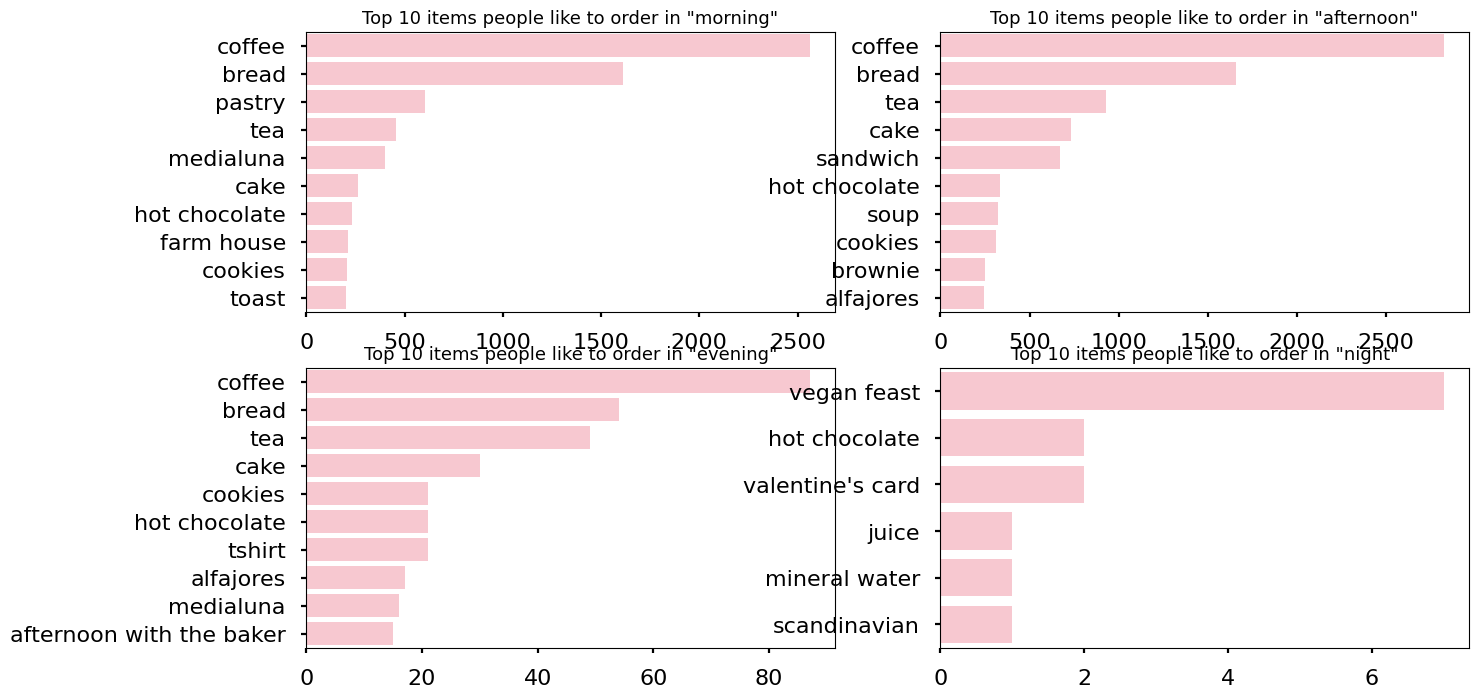

In [ ]:
data = df.groupby(['period_day','Item'])['Transaction'].count().reset_index().sort_values(['period_day','Transaction'],ascending=False)
day = ['morning','afternoon','evening','night']

plt.figure(figsize=(15,8))
for i,j in enumerate(day):
    plt.subplot(2,2,i+1)
    df1 = data[data.period_day==j].head(10)
    sns.barplot(data=df1, y=df1.Item, x=df1.Transaction, color='pink')
    plt.xlabel('')
    plt.ylabel('')
    plt.title('Top 10 items people like to order in "{}"'.format(j), size=13)

plt.show()

# Apriori Algorithm

In [ ]:
from mlxtend.frequent_patterns import association_rules, apriori

In [ ]:
transactions_str = df.groupby(['Transaction', 'Item'])['Item'].count().reset_index(name ='Count')
transactions_str

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Transaction,Item,Count
0,1,bread,1
1,2,scandinavian,2
2,3,cookies,1
3,3,hot chocolate,1
4,3,jam,1
...,...,...,...
18882,9682,tacos/fajita,1
18883,9682,tea,1
18884,9683,coffee,1
18885,9683,pastry,1


In [ ]:
# making a mxn matrice where m=transaction and n=items and each row represents whether the item was in the transaction or not
my_basket = transactions_str.pivot_table(index='Transaction', columns='Item', values='Count', aggfunc='sum').fillna(0)


my_basket.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# making a function which returns 0 or 1
# 0 means item was not in that transaction, 1 means item present in that transaction

def encode(x):
    if x<=0:
        return 0
    if x>=1:
        return 1

# applying the function to the dataset

my_basket_sets = my_basket.applymap(encode)
my_basket_sets.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Item,adjustment,afternoon with the baker,alfajores,argentina night,art tray,bacon,baguette,bakewell,bare popcorn,basket,...,the bart,the nomad,tiffin,toast,truffles,tshirt,valentine's card,vegan feast,vegan mincepie,victorian sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# using the 'apriori algorithm' with min_support=0.01 (1% of 9465)
# It means the item should be present in atleast 94 transaction out of 9465 transactions only when we considered that item in
# frequent itemset
frequent_items = apriori(my_basket_sets, min_support = 0.01,use_colnames = True)
frequent_items

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.036344,(alfajores)
1,0.016059,(baguette)
2,0.327205,(bread)
3,0.040042,(brownie)
4,0.103856,(cake)
...,...,...
56,0.023666,"(toast, coffee)"
57,0.014369,"(tea, sandwich)"
58,0.010037,"(bread, cake, coffee)"
59,0.011199,"(bread, pastry, coffee)"


In [ ]:
# now making the rules from frequent itemset generated above

rules = association_rules(frequent_items, metric = "lift", min_threshold = 1)
rules.sort_values('confidence', ascending = False, inplace = True)
rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
30,(toast),(coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
28,(spanish brunch),(coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
18,(medialuna),(coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
22,(pastry),(coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
0,(alfajores),(coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
16,(juice),(coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919,0.108738
25,(sandwich),(coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384,0.109205
6,(cake),(coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
26,(scone),(coffee),0.034548,0.478394,0.018067,0.522936,1.093107,0.001539,1.093366,0.088224
12,(cookies),(coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700


In [ ]:
# arranging the data from highest to lowest with respect to 'confidence'

rules.sort_values('confidence', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
30,(toast),(coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
28,(spanish brunch),(coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
18,(medialuna),(coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
22,(pastry),(coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
0,(alfajores),(coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
16,(juice),(coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919,0.108738
25,(sandwich),(coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384,0.109205
6,(cake),(coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
26,(scone),(coffee),0.034548,0.478394,0.018067,0.522936,1.093107,0.001539,1.093366,0.088224
12,(cookies),(coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700


##EJEMPLO 3 REGRESIÓN LOGISTICA

# Importamos librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Vamos a cargar los datos en un DF llamado Train

In [ ]:
train = pd.read_csv("train.csv")
df_test=pd.read_csv("test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train.drop([889,890],inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Ahora vamos a preparar los datos buscando los datos faltantes

In [ ]:
train.isnull().tail() # obtenemos una matrix boleana donde se muestra datos nulos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
884,False,False,False,False,False,False,False,False,False,False,True,False
885,False,False,False,False,False,False,False,False,False,False,True,False
886,False,False,False,False,False,False,False,False,False,False,True,False
887,False,False,False,False,False,False,False,False,False,False,False,False
888,False,False,False,False,False,True,False,False,False,False,True,False


# Como ya tenemos los datos nulos vamos a hacer un mapa de calor para tener una mejor visualiza

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

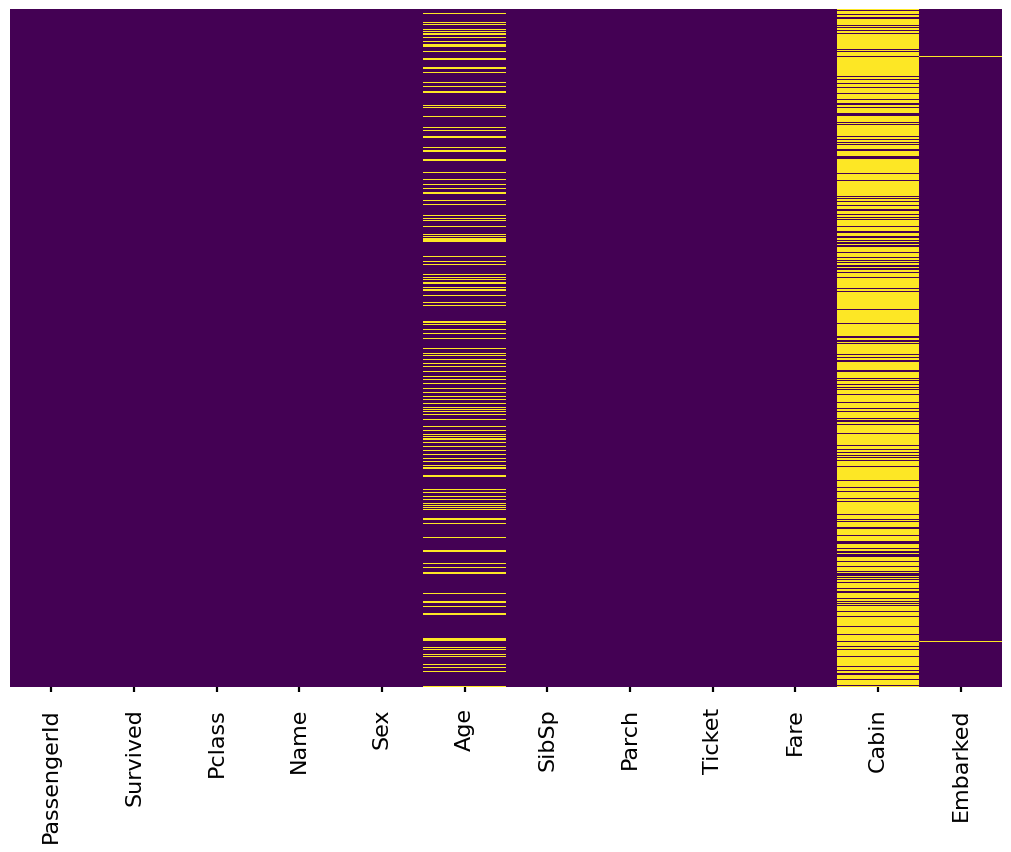

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis') # eliminamos eje Y , leyenda de las barras

# Visualizamos rapidamente cuantos sobrevientes hubieron

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Survived', ylabel='count'>

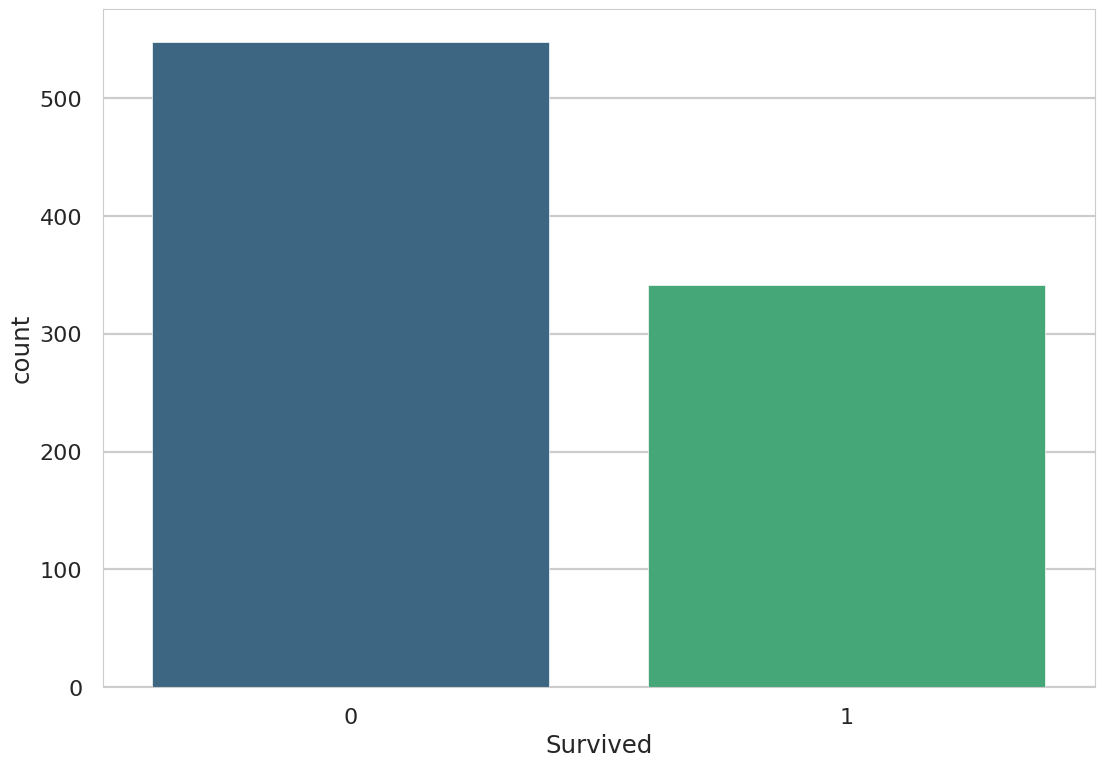

In [ ]:
sns.set_style('whitegrid') # Estilo de la grilla
sns.countplot(x='Survived',data=train,palette='viridis')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Survived', ylabel='count'>

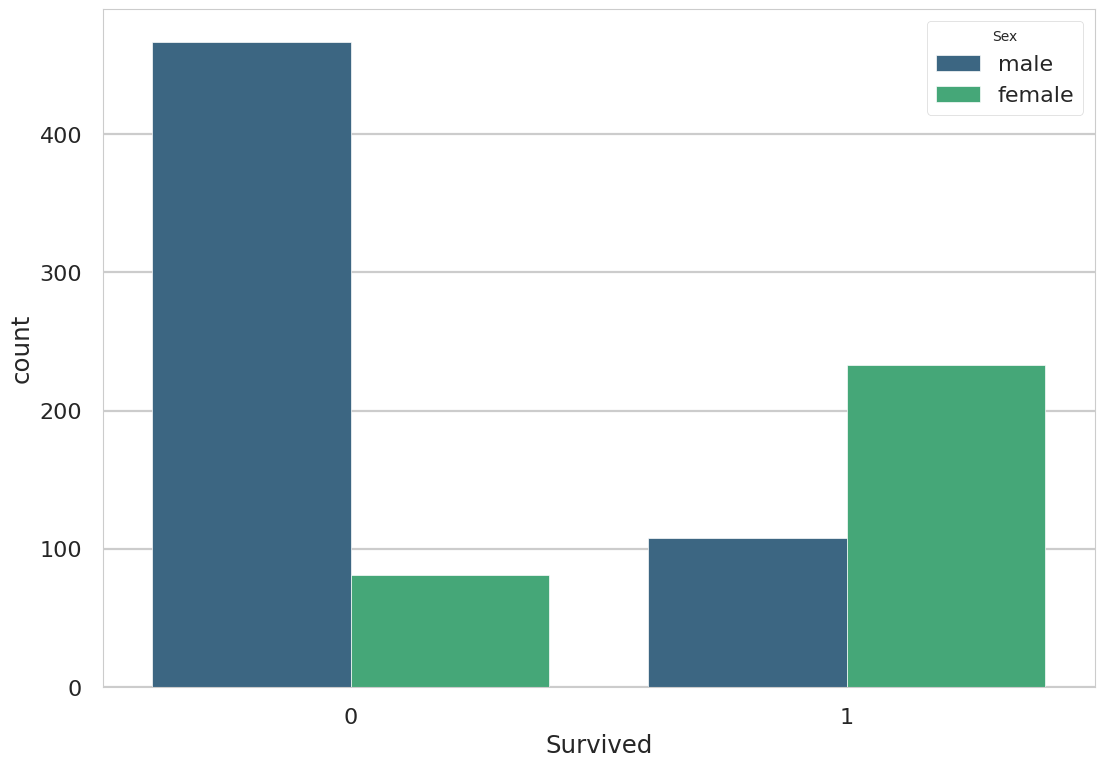

In [ ]:
sns.countplot(x='Survived',hue='Sex',data=train,palette='viridis') # si deseamos hacer un matizado con el genero

# ANALISIS GENERO:
Es muy facil observar que la mayoria de personas que no sobrevivieron eran hombres y a su vez las personas que sobrevivieron en su mayoria (casi el doble ) eran mujeres

In [ ]:
# Ahora hagamos el mismo analisis pero con la clase social

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Survived', ylabel='count'>

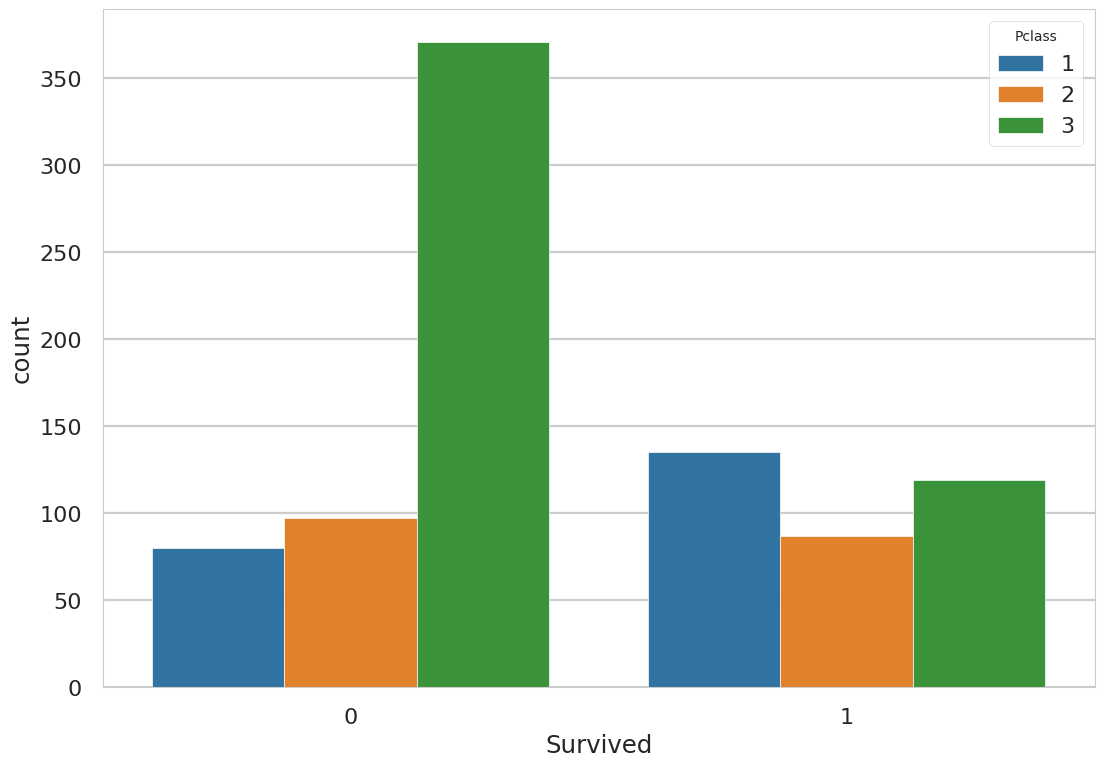

In [ ]:
sns.countplot(x='Survived',hue='Pclass',data=train)

# Numero de pasajeros por clase

In [ ]:
train['Pclass'].value_counts() # Para evaluar el numero de pasajeros de la muestra

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3    490
1    215
2    184
Name: Pclass, dtype: int64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Pclass', ylabel='count'>

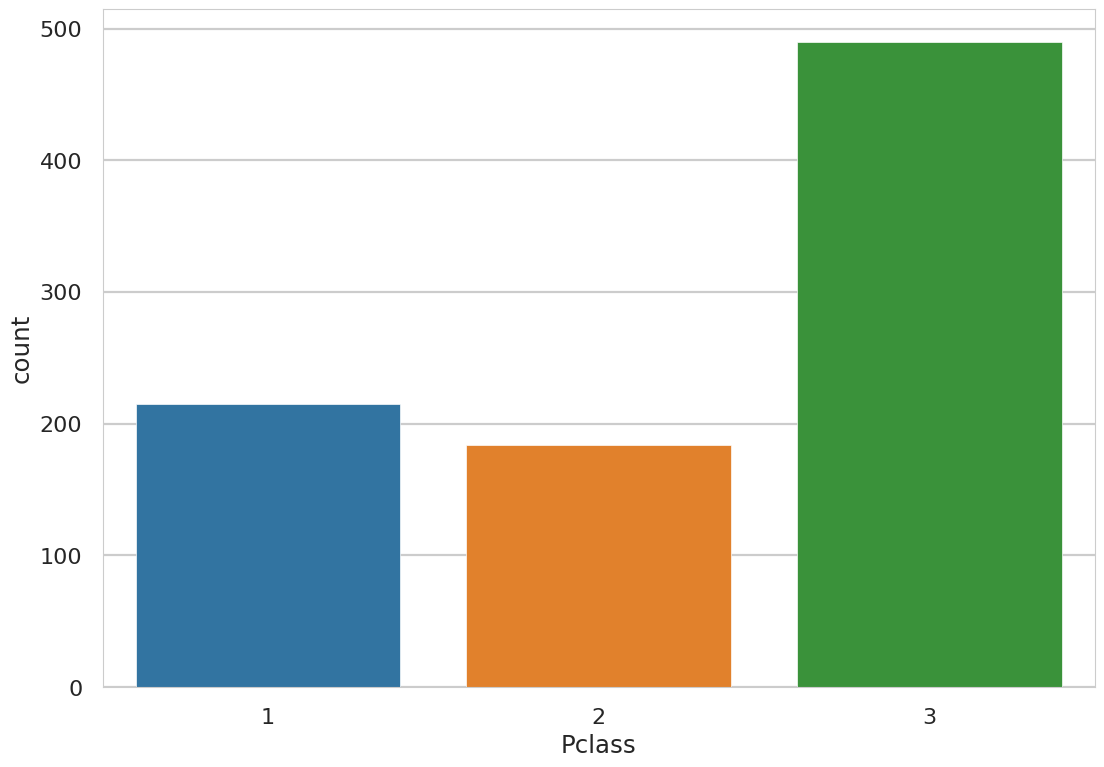

In [ ]:
sns.countplot(x='Pclass',data=train)

# Limpiando nuestros datos
​
En esta fase vamos a preparar nuestros datos para los algoritmos de machine learning , como primer paso vamos a realizar un diagrama de cajas para la edad y de esa manera observar el promedio de la edad por clase social

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='Pclass', ylabel='Age'>

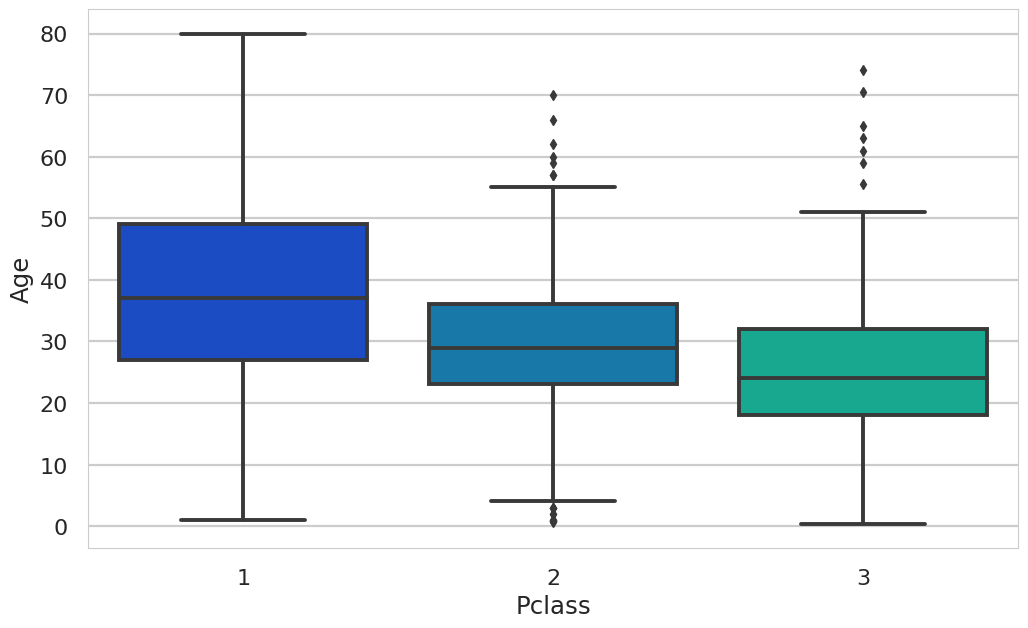

In [ ]:
plt.figure(figsize=(12, 7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')

# Analisis :

Podemos observar que la edad promedio por clase social es :

* 1ra clase la edad promedio es 37 años aprox.
* 2da clase la edad promedio es 29 años aprox.
* 3ra clase la edad promedio es 24 años aprox.

In [ ]:
# Creamos la funcion de imputacion de datos para la edad

def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]

    if pd.isnull(Age):

        if Pclass == 1:
            return 37

        elif Pclass == 2:
            return 29

        else:
            return 24

    else:
        return Age

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Aplicamos la funcion para limpiar datos de edad y actualizarlos

In [ ]:
train['Age'] = train[['Age','Pclass']].apply(impute_age,axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Aplicamos nuevamente el heatmap para verificar si los datos fueron limpiados correctamente

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

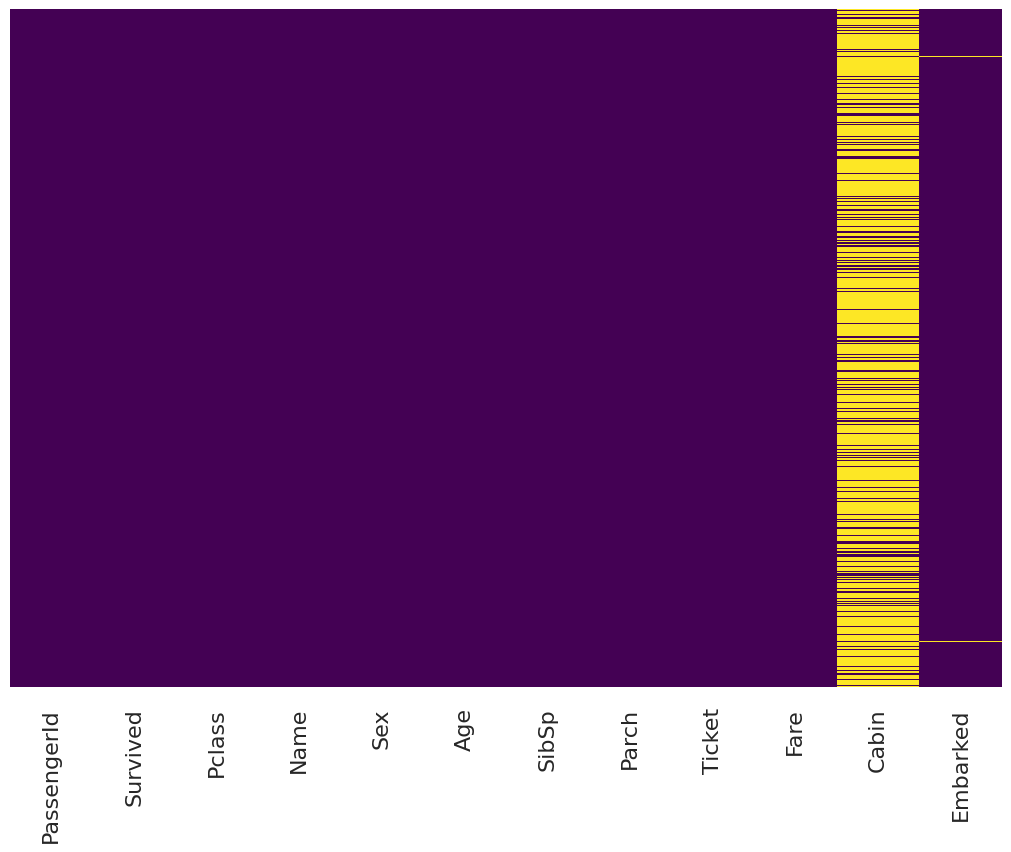

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis') # de esta manera se observa los missing Data

In [ ]:
# como podemos analizar hay muchos datos faltantes en las cabinas y quizas no sea un informacion importante
# entonces lo que hacemos es suprimir esta columna

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train.drop('Cabin',axis=1,inplace=True) # recordar que el implace es para hacer un guardado definitivo

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

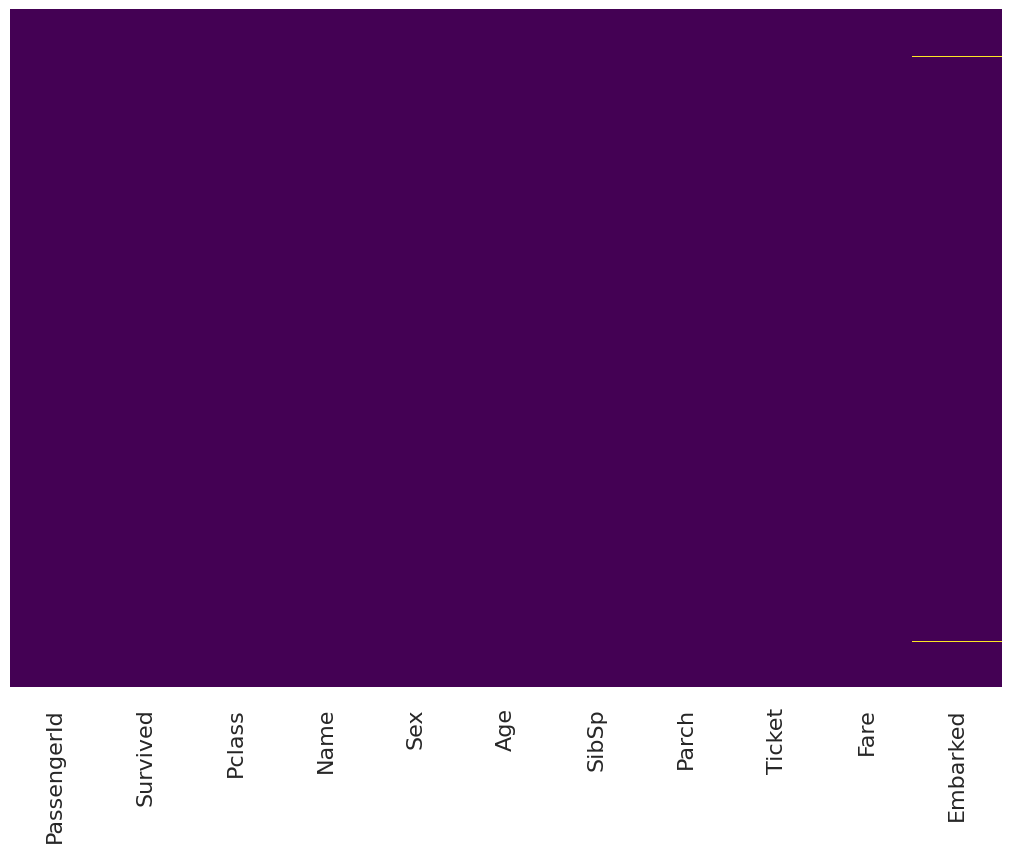

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis') # de esta manera se observa los missing Data

# Retiro de las variables que no tienen importancia para nuestra prediccion
​
Realizamos el retiro de las variables que no tienen importancia dentro del estudio o no son numericos

In [ ]:
train.drop(['Name','Embarked','SibSp','Ticket','Parch','Fare','Age'],axis=1,inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PassengerId,Survived,Pclass,Sex
0,1,0,3,male
1,2,1,1,female
2,3,1,3,female
3,4,1,1,female
4,5,0,3,male


# Conversion de las variables categoricas

Tendremos que convertir características categóricas a variables ficticias utilizando pandas! De lo contrario, nuestro algoritmo de aprendizaje automático no podrá tomar directamente esas características como entradas

In [ ]:
sex = pd.get_dummies(train['Sex'],drop_first=True) # con pandas caracterizamos las variables categoricas
#clase = pd.get_dummies(train['Pclass'],drop_first=True) # con pandas caracterizamos las variables categoricas

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train = pd.concat([train,sex],axis=1)  # Realizamos concatenación para ingresar las variables convertidas

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PassengerId,Survived,Pclass,Sex,male
0,1,0,3,male,1
1,2,1,1,female,0
2,3,1,3,female,0
3,4,1,1,female,0
4,5,0,3,male,1


In [ ]:
train.drop(['Sex'],axis=1,inplace=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
train.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PassengerId,Survived,Pclass,male
0,1,0,3,1
1,2,1,1,0
2,3,1,3,0
3,4,1,1,0
4,5,0,3,1


# Sobrevivientes por clases ( porcentaje %)

In [ ]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Pclass,Survived
0,1,0.627907
1,2,0.472826
2,3,0.242857


# Construyendo el modelo de regresion :
​
Una vez ya tengamos nuestros datos caracterizados y limpios , procedemos  a dividir nuestros datos en un conjunto de entrenamiento y un conjunto de prueba

In [ ]:
X=train.drop('Survived',axis=1)
y=train['Survived']
X_test  = df_test.drop("PassengerId",axis=1).copy()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.47, random_state=101)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Prediccion del modelo

In [ ]:
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lrmodel = LogisticRegression() # Creamos la instancia
lrmodel.fit(X_train,y_train)   # Ajustamos el modelo con los datos de entrenamiento

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LogisticRegression()

In [ ]:
prediccion=lrmodel.predict(X_test) # Prediccion de los datos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lrmodel.score(X_train, y_train)
logistic_score = round(lrmodel.score(X_train, y_train)*100,2)
logistic_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


76.65

In [ ]:
from sklearn.ensemble import RandomForestClassifier
ranfor = RandomForestClassifier()
ranfor.fit(X_train, y_train)
pred_rf = ranfor.predict(X_test)

ranfor.score(X_train, y_train)

ranfor_score = round(ranfor.score(X_train, y_train)*100,2)
ranfor_score

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100.0

In [ ]:
df_final = pd.DataFrame({"Models": [ 'Logistic Regression',  'Random Forest'],
                       "Score": [logistic_score, ranfor_score]})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_final.sort_values(by= "Score", ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Models,Score
1,Random Forest,100.00
0,Logistic Regression,76.65


# Evaluaciones de los modelos

In [ ]:
from sklearn.metrics import classification_report # Nos indicara la precision de nuestro modelo
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print (classification_report(y_test,prediccion))

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       257
           1       0.81      0.70      0.75       161

    accuracy                           0.82       418
   macro avg       0.82      0.80      0.80       418
weighted avg       0.82      0.82      0.82       418



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
confusion_matrix(y_test,prediccion)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([[230,  27],
       [ 49, 112]])

# Archivo con prediccion por Regresion Logistica


In [ ]:
final_report_LogR = pd.DataFrame({"PassengerId": df_test["PassengerId"],
                       "Survived" : prediccion})

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
final_report_LogR.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [ ]:
final_report_LogR.to_csv('final_Pred_LogR.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
